<a href="https://colab.research.google.com/github/yuvipaloozie/Data-Driven-Swing-Trading/blob/main/SwingTradingAlgoModel1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!rm -rf /root/.cache/matplotlib
!pip install yfinance ta xgboost plotly quantstats
!pip install --upgrade pandas

import yfinance as yf
import pandas as pd
import numpy as np
import ta
import xgboost as xgb
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Suppress pandas warnings
pd.options.mode.chained_assignment = None  # default='warn'

In [21]:

# Asset Parameters
VOLATILE_TICKER = 'TSLA'
MARKET_TICKER = 'SPY'
START_DATE = '2015-01-01'
END_DATE = '2024-12-31'

# Triple Barrier Parameter
PROFIT_TAKE_PERC = 0.25
STOP_LOSS_PERC = 0.15
TIME_BARRIER_DAYS = 30

# Model Parameters
N_SPLITS = 5
PROB_THRESHOLD = 0.60
FEATURE_SET = [

    'RSI',
    'MACD',
    'EMA_DIST',
    'EMA_CROSS_MED',
    'EMA_CROSS_LONG',
    'ATR_PERCENT',


    # Commenting out extra indicators since model overfits
    #'Hist_Vol_30D',
    #'VIX_Close',

    #'SPY_Regime',

    #'Stoch_K',
    #'Z_Score_20'
]

# Monte Carlo Parameters
N_SIMULATIONS = 5000
SIMULATION_DAYS = 252

In [22]:

data = yf.download(VOLATILE_TICKER, start=START_DATE, end=END_DATE)
if isinstance(data.columns, pd.MultiIndex):
    data.columns = ['_'.join(col).strip() for col in data.columns.values]
# Rename columns to generic names (Open, High, Low, Close, Volume)
data = data.rename(columns={col: col.replace(f'_{VOLATILE_TICKER}', '') for col in data.columns if f'_{VOLATILE_TICKER}' in col})

market_data = yf.download(MARKET_TICKER, start=START_DATE, end=END_DATE)

vix_data = yf.download('^VIX', start=START_DATE, end=END_DATE)

if isinstance(market_data.columns, pd.MultiIndex):
    market_data.columns = ['_'.join(col).strip() for col in market_data.columns.values]
market_data = market_data.rename(columns={col: col.replace(f'_{MARKET_TICKER}', '') for col in market_data.columns if f'_{MARKET_TICKER}' in col})

data['Market_Returns'] = market_data['Close'].pct_change()


data['Stock_Returns'] = data['Close'].pct_change()
print(f"Data loaded for {VOLATILE_TICKER} and {MARKET_TICKER}.")
print(data.head())

/tmp/ipython-input-3217629624.py:1: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3217629624.py:7: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3217629624.py:9: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed

Data loaded for TSLA and SPY.
                Close       High        Low       Open    Volume  \
Date                                                               
2015-01-02  14.620667  14.883333  14.217333  14.858000  71466000   
2015-01-05  14.006000  14.433333  13.810667  14.303333  80527500   
2015-01-06  14.085333  14.280000  13.614000  14.004000  93928500   
2015-01-07  14.063333  14.318667  13.985333  14.223333  44526000   
2015-01-08  14.041333  14.253333  14.000667  14.187333  51637500   

            Market_Returns  Stock_Returns  
Date                                       
2015-01-02             NaN            NaN  
2015-01-05       -0.018060      -0.042041  
2015-01-06       -0.009419       0.005664  
2015-01-07        0.012461      -0.001562  
2015-01-08        0.017745      -0.001564  


In [23]:
data['SMA_200'] = data['Close'].rolling(window=200).mean()
data['EMA_200'] = ta.trend.ema_indicator(data['Close'], window=200)
data['EMA_100'] = ta.trend.ema_indicator(data['Close'], window=100)
data['EMA_50'] = ta.trend.ema_indicator(data['Close'], window=50)

fig = go.Figure()


fig.add_trace(go.Candlestick(
    x=data.index,
    open=data['Open'],
    high=data['High'],
    low=data['Low'],
    close=data['Close'],
    name=f'{VOLATILE_TICKER} Candlesticks'
))


fig.add_trace(go.Scatter(
    x=data.index,
    y=data['EMA_200'],
    mode='lines',
    line=dict(color='orange', width=2),
    name='200-Day EMA'
))
fig.add_trace(go.Scatter(
    x=data.index,
    y=data['EMA_100'],
    mode='lines',
    line=dict(color='blue', width=2, dash='dot'),
    name='100-Day EMA'
))
fig.add_trace(go.Scatter(
    x=data.index,
    y=data['EMA_50'],
    mode='lines',
    line=dict(color='pink', width=2, dash='dot'),
    name='50-Day EMA'
))

# Update layout
fig.update_layout(
    title=f'{VOLATILE_TICKER} Historical Price Action ({START_DATE} to {END_DATE})',
    yaxis_title='Price (USD)',
    xaxis_title='Date',
    height=600,
    legend_title='Legend',
    xaxis_rangeslider_visible=False
)

fig.update_yaxes(type="log")
fig.show()

In [24]:
data = ta.add_all_ta_features(
    data, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True
)


data['RSI'] = data['momentum_rsi']
data['MACD'] = data['trend_macd_diff']
data['ATR_PERCENT'] = (data['volatility_atr'] / data['Close']) * 100


data['EMA_DIST'] = (data['Close'] - data['EMA_200']) / data['Close'] * 100
data['EMA_CROSS_MED'] = np.where(data['EMA_50'] > data['EMA_100'], 1, 0)

if 'EMA_50' not in data.columns:
    data['EMA_50'] = ta.trend.ema_indicator(data['Close'], window=50)
if 'EMA_200' not in data.columns:
    data['EMA_200'] = ta.trend.ema_indicator(data['Close'], window=200)


data['EMA_CROSS_LONG'] = np.where(data['EMA_50'] > data['EMA_200'], 1, 0)

print(f"Features created. Using feature set: {FEATURE_SET}")

data['Hist_Vol_30D'] = data['Stock_Returns'].rolling(window=30).std() * np.sqrt(252)

data['VIX_Close'] = vix_data['Close']
data['VIX_Close'] = data['VIX_Close'].ffill()

spy_ema_50 = ta.trend.ema_indicator(market_data['Close'], window=50)
spy_ema_200 = ta.trend.ema_indicator(market_data['Close'], window=200)


market_data['SPY_Regime'] = np.where(spy_ema_50 > spy_ema_200, 1, 0)

data['SPY_Regime'] = market_data['SPY_Regime']
data['SPY_Regime'] = data['SPY_Regime'].ffill()

data['Stoch_K'] = ta.momentum.stoch(data['High'], data['Low'], data['Close'], window=14)


sma_20 = data['Close'].rolling(window=20).mean()
std_20 = data['Close'].rolling(window=20).std()
data['Z_Score_20'] = (data['Close'] - sma_20) / std_20



print(f"Features created. Using feature set: {FEATURE_SET}")

print(data[FEATURE_SET].tail())

/usr/local/lib/python3.12/dist-packages/ta/trend.py:1030: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`



Features created. Using feature set: ['RSI', 'MACD', 'EMA_DIST', 'EMA_CROSS_MED', 'EMA_CROSS_LONG', 'ATR_PERCENT']
Features created. Using feature set: ['RSI', 'MACD', 'EMA_DIST', 'EMA_CROSS_MED', 'EMA_CROSS_LONG', 'ATR_PERCENT']
                  RSI      MACD   EMA_DIST  EMA_CROSS_MED  EMA_CROSS_LONG  \
Date                                                                        
2024-12-23  62.731818 -0.807371  39.205807              1               1   
2024-12-24  68.422829 -0.059537  42.940463              1               1   
2024-12-26  65.645587 -0.422695  41.499372              1               1   
2024-12-27  58.585163 -2.376070  38.071501              1               1   
2024-12-30  54.576261 -4.693767  35.599534              1               1   

            ATR_PERCENT  
Date                     
2024-12-23     5.792197  
2024-12-24     5.551848  
2024-12-26     5.401443  
2024-12-27     5.754440  
2024-12-30     5.736962  


In [25]:

plot_data = data.loc['2022-01-01':]

fig = make_subplots(
    rows=4,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.03,
    subplot_titles=(
        '1. Price Action',
        '2. Mean-Reversion Oscillators',
        '3. Volatility Regime',
        '4. Trend & Market Regime'
    ),
    specs=[[{"secondary_y": False}],  # Row 1 (Price)
           [{"secondary_y": True}],   # Row 2 (Mean Reversion)
           [{"secondary_y": True}],   # Row 3 (Volatility)
           [{"secondary_y": False}]]  # Row 4 (Trend)
)


fig.add_trace(go.Candlestick(
    x=plot_data.index,
    open=plot_data['Open'], high=plot_data['High'],
    low=plot_data['Low'], close=plot_data['Close'],
    name='Price'
), row=1, col=1)
fig.update_yaxes(title_text="Price", row=1, col=1)


# Stochastic Mean Reversion
fig.add_trace(go.Scatter(
    x=plot_data.index, y=plot_data['Stoch_K'],
    mode='lines', line=dict(color='purple'), name='Stoch %K'
), row=2, col=1)
fig.add_hline(y=80, line=dict(color='red', dash='dot'), row=2, col=1)
fig.add_hline(y=20, line=dict(color='green', dash='dot'), row=2, col=1)
# Z-Score
# We need a secondary y-axis for Z-Score
fig.add_trace(go.Scatter(
    x=plot_data.index, y=plot_data['Z_Score_20'],
    mode='lines', line=dict(color='orange'), name='Z-Score (20d)'
), row=2, col=1, secondary_y=True)
fig.update_yaxes(title_text="Stochastic", row=2, col=1, secondary_y=False)
fig.update_yaxes(title_text="Z-Score", row=2, col=1, secondary_y=True)


# --- 3. Volatility Regime ---
fig.add_trace(go.Scatter(
    x=plot_data.index, y=plot_data['Hist_Vol_30D'],
    mode='lines', line=dict(color='blue'), name='Hist. Vol (30d)'
), row=3, col=1)
# VIX on secondary axis
fig.add_trace(go.Scatter(
    x=plot_data.index, y=plot_data['VIX_Close'],
    mode='lines', line=dict(color='gray'), name='VIX'
), row=3, col=1, secondary_y=True)
fig.update_yaxes(title_text="Stock Vol", row=3, col=1, secondary_y=False)
fig.update_yaxes(title_text="VIX", row=3, col=1, secondary_y=True)

# These are binary (0 or 1), so they plot as "steps"
fig.add_trace(go.Scatter(
    x=plot_data.index, y=plot_data['EMA_CROSS_LONG'],
    mode='lines', line=dict(color='green', width=2), name='Stock Trend (50>200)'
), row=4, col=1)
fig.add_trace(go.Scatter(
    x=plot_data.index, y=plot_data['SPY_Regime'],
    mode='lines', line=dict(color='red', dash='dot', width=2), name='Market Trend (SPY)'
), row=4, col=1)
fig.update_yaxes(title_text="Regime (1=On)", row=4, col=1)


fig.update_layout(
    height=1200,
    title_text=f'{VOLATILE_TICKER} Quant Dashboard (2022-Present)',
    xaxis_rangeslider_visible=False,
    legend_title='Legend'
)
fig.show()

In [26]:

def get_triple_barrier_labels(prices, profit_take_perc, stop_loss_perc, time_barrier_days):
    labels = pd.Series(np.nan, index=prices.index)

    for i in range(len(prices)):
        entry_price = prices.iloc[i]
        profit_target = entry_price * (1 + profit_take_perc)
        stop_loss_target = entry_price * (1 - stop_loss_perc)
        window = prices.iloc[i+1 : i+1+TIME_BARRIER_DAYS]

        if window.empty:
            break

        profit_hit = window[window >= profit_target].first_valid_index()
        stop_loss_hit = window[window <= stop_loss_target].first_valid_index()

        if profit_hit is None and stop_loss_hit is None:
            labels.iloc[i] = 0
        elif profit_hit is not None and stop_loss_hit is None:
            labels.iloc[i] = 1
        elif profit_hit is None and stop_loss_hit is not None:
            labels.iloc[i] = 0
        else:
            if profit_hit < stop_loss_hit:
                labels.iloc[i] = 1
            else:
                labels.iloc[i] = 0

    return labels


data['label'] = get_triple_barrier_labels(
    data['Close'],
    profit_take_perc=PROFIT_TAKE_PERC,
    stop_loss_perc=STOP_LOSS_PERC,
    time_barrier_days=TIME_BARRIER_DAYS
)
print("Labels created.")

Labels created.


Total samples for training: 2315
Class distribution (1=Win, 0=Loss/Timeout):
label
0.0    0.755508
1.0    0.244492
Name: proportion, dtype: float64

Starting walk-forward training...
  Split 1/5 complete. Test F1-Score: 0.3544 (Accuracy: 0.8675)
  Split 2/5 complete. Test F1-Score: 0.1070 (Accuracy: 0.4364)
  Split 3/5 complete. Test F1-Score: 0.4496 (Accuracy: 0.6312)
  Split 4/5 complete. Test F1-Score: 0.4053 (Accuracy: 0.6494)
  Split 5/5 complete. Test F1-Score: 0.3056 (Accuracy: 0.7403)
Model training complete.

Plotting feature importance from last-trained model...


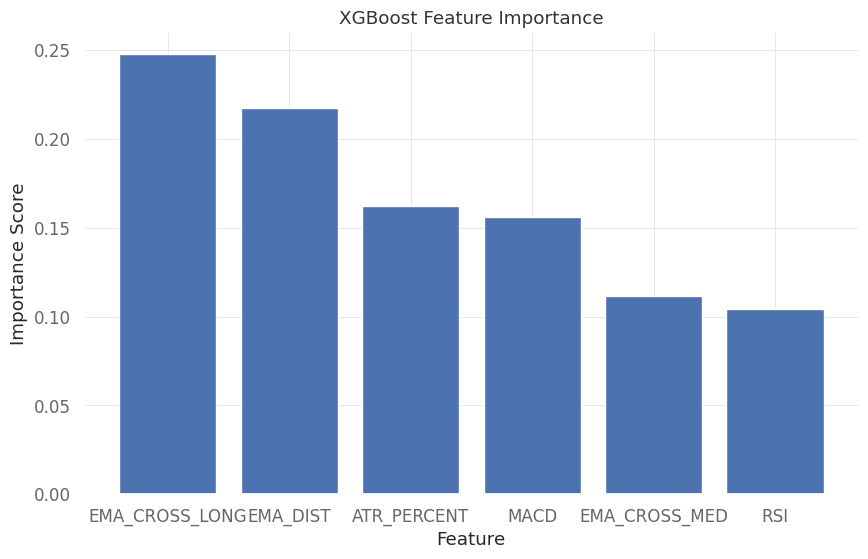

          Feature  Importance
4  EMA_CROSS_LONG    0.247760
2        EMA_DIST    0.217766
5     ATR_PERCENT    0.162252
1            MACD    0.156169
3   EMA_CROSS_MED    0.111510
0             RSI    0.104544


In [27]:
from sklearn.metrics import f1_score #

# Create final X and y
X = data[FEATURE_SET]
y = data['label']


combined = pd.concat([X, y], axis=1).dropna()
X = combined[FEATURE_SET]
y = combined['label']

print(f"Total samples for training: {len(y)}")
print(f"Class distribution (1=Win, 0=Loss/Timeout):\n{y.value_counts(normalize=True)}")

tscv = TimeSeriesSplit(n_splits=N_SPLITS)
all_predictions = pd.Series(np.nan, index=y.index)
all_probs = pd.Series(np.nan, index=y.index)

print("\nStarting walk-forward training...")
split_num = 1
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    weight_ratio = y_train.value_counts()[0.0] / y_train.value_counts()[1.0]

    model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        n_estimators=100,
        random_state=42,
        scale_pos_weight=weight_ratio,

        max_depth=3,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8
    )

    model.fit(X_train_scaled, y_train)

    test_probs = model.predict_proba(X_test_scaled)[:, 1]
    test_preds = (test_probs > PROB_THRESHOLD).astype(int)

    all_predictions.iloc[test_index] = test_preds
    all_probs.iloc[test_index] = test_probs

    f1 = f1_score(y_test, test_preds)
    print(f"  Split {split_num}/{N_SPLITS} complete. Test F1-Score: {f1:.4f} (Accuracy: {accuracy_score(y_test, test_preds):.4f})")
    split_num += 1

print("Model training complete.")

print("\nPlotting feature importance from last-trained model...")
try:

    importance = model.feature_importances_

    # Create a DataFrame for easy plotting
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)


    plt.figure(figsize=(10, 6))
    plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.title('XGBoost Feature Importance')
    plt.xlabel('Feature')
    plt.ylabel('Importance Score')
    plt.show()

    print(feature_importance_df)

except Exception as e:
    print(f"Could not plot feature importance: {e}")

In [28]:

backtest_df = data.loc[all_predictions.index].copy()
backtest_df['Signal_Prob'] = all_probs
backtest_df['Signal'] = all_predictions

backtest_df['Signal'] = backtest_df['Signal'].shift(1)

backtest_df['Strategy_Returns'] = backtest_df['Stock_Returns'] * backtest_df['Signal']

backtest_df['Cumulative_Strategy_Returns'] = (1 + backtest_df['Strategy_Returns']).cumprod()
backtest_df['Cumulative_Stock_BH_Returns'] = (1 + backtest_df['Stock_Returns']).cumprod()
backtest_df['Cumulative_Market_BH_Returns'] = (1 + backtest_df['Market_Returns']).cumprod()

print("Backtest calculations complete.")

Backtest calculations complete.


In [29]:
buy_signals = backtest_df[backtest_df['Signal'] == 1]

# We'll plot just the last ~2 years of signals to see them clearly
plot_df = backtest_df.loc['2022-01-01':]
plot_signals = buy_signals.loc['2022-01-01':]

fig = go.Figure()
fig.add_trace(go.Candlestick(
    x=plot_df.index,
    open=plot_df['Open'],
    high=plot_df['High'],
    low=plot_df['Low'],
    close=plot_df['Close'],
    name=f'{VOLATILE_TICKER} Price'
))


fig.add_trace(go.Scatter(
    x=plot_signals.index,
    # Place the marker just below the low of that day for visibility
    y=plot_signals['Low'] * 0.98,
    mode='markers',
    marker=dict(
        color='green',
        symbol='triangle-up',
        size=10
    ),
    name=f'Model "IN" (Prob > {PROB_THRESHOLD})'
))


fig.update_layout(
    title=f'Model Signals on {VOLATILE_TICKER} Price (2022-Present)',
    xaxis_title='Date',
    yaxis_title='Price (USD)',
    height=600,
    xaxis_rangeslider_visible=False,
    legend_title='Legend'
)

fig.show()

Plot saved as 'strategy_comparison.png'


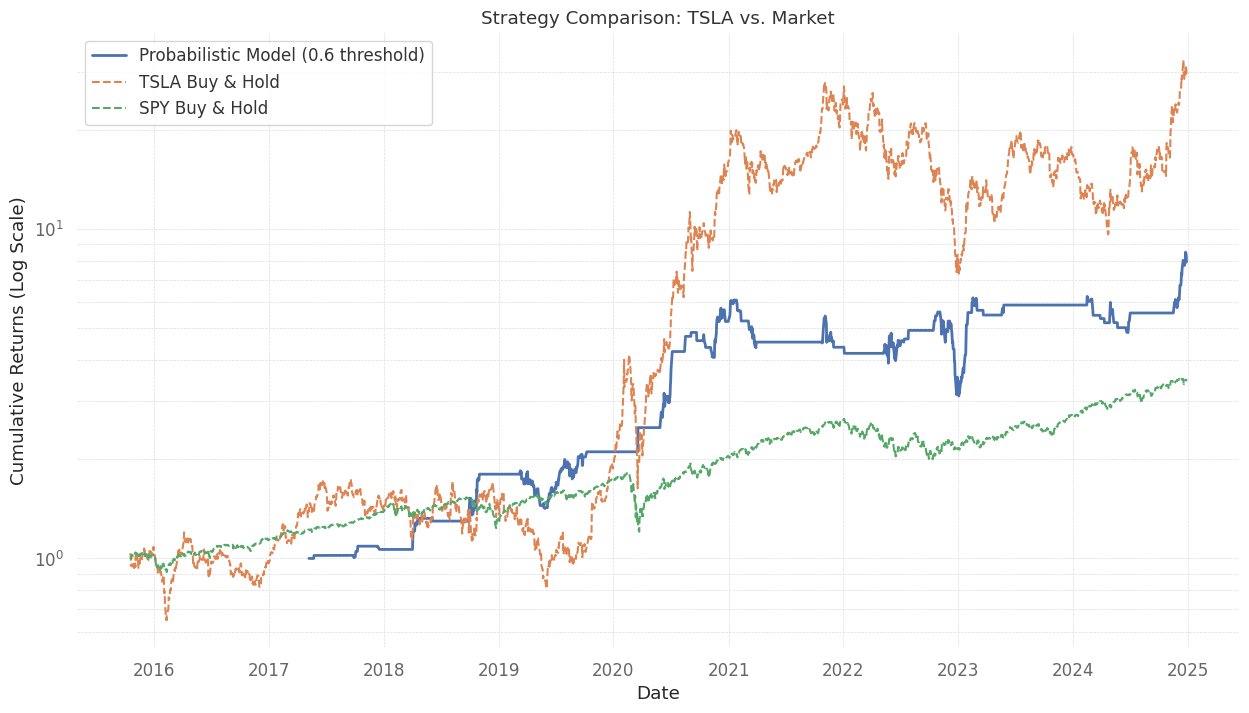


Historical Performance Metrics
Strategy Returns: 7.94x
TSLA B&H Returns: 29.26x
SPY B&H Returns: 3.45x


In [30]:
plt.figure(figsize=(15, 8))
plt.plot(
    backtest_df['Cumulative_Strategy_Returns'],
    label=f"Probabilistic Model ({PROB_THRESHOLD} threshold)",
    linewidth=2
)
plt.plot(
    backtest_df['Cumulative_Stock_BH_Returns'],
    label=f"{VOLATILE_TICKER} Buy & Hold",
    linestyle='--',
    linewidth=1.5
)
plt.plot(
    backtest_df['Cumulative_Market_BH_Returns'],
    label=f"{MARKET_TICKER} Buy & Hold",
    linestyle='--',
    linewidth=1.5
)

plt.title(f'Strategy Comparison: {VOLATILE_TICKER} vs. Market')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns (Log Scale)')
plt.yscale('log')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.savefig('strategy_comparison.png')
print("Plot saved as 'strategy_comparison.png'")
plt.show()


try:
    print("\nHistorical Performance Metrics")
    print(f"Strategy Returns: {backtest_df['Cumulative_Strategy_Returns'].iloc[-1]:.2f}x")
    print(f"{VOLATILE_TICKER} B&H Returns: {backtest_df['Cumulative_Stock_BH_Returns'].iloc[-1]:.2f}x")
    print(f"{MARKET_TICKER} B&H Returns: {backtest_df['Cumulative_Market_BH_Returns'].iloc[-1]:.2f}x")
except Exception as e:
    print(f"Could not print final performance: {e}")

In [31]:
print("Running Stress Test")

strategy_daily_returns = backtest_df['Strategy_Returns'].dropna()

sim_results = np.zeros((SIMULATION_DAYS + 1, N_SIMULATIONS))
sim_results[0, :] = 1.0

for i in range(N_SIMULATIONS):
    sim_returns = np.random.choice(
        strategy_daily_returns,
        SIMULATION_DAYS,
        replace=True
    )
    sim_results[1:, i] = (1 + sim_returns).cumprod()

print(f"Ran {N_SIMULATIONS} simulations of {SIMULATION_DAYS} days each.")

Running Stress Test
Ran 5000 simulations of 252 days each.


Monte Carlo Plot
Plot saved as 'monte_carlo_spaghetti.png'


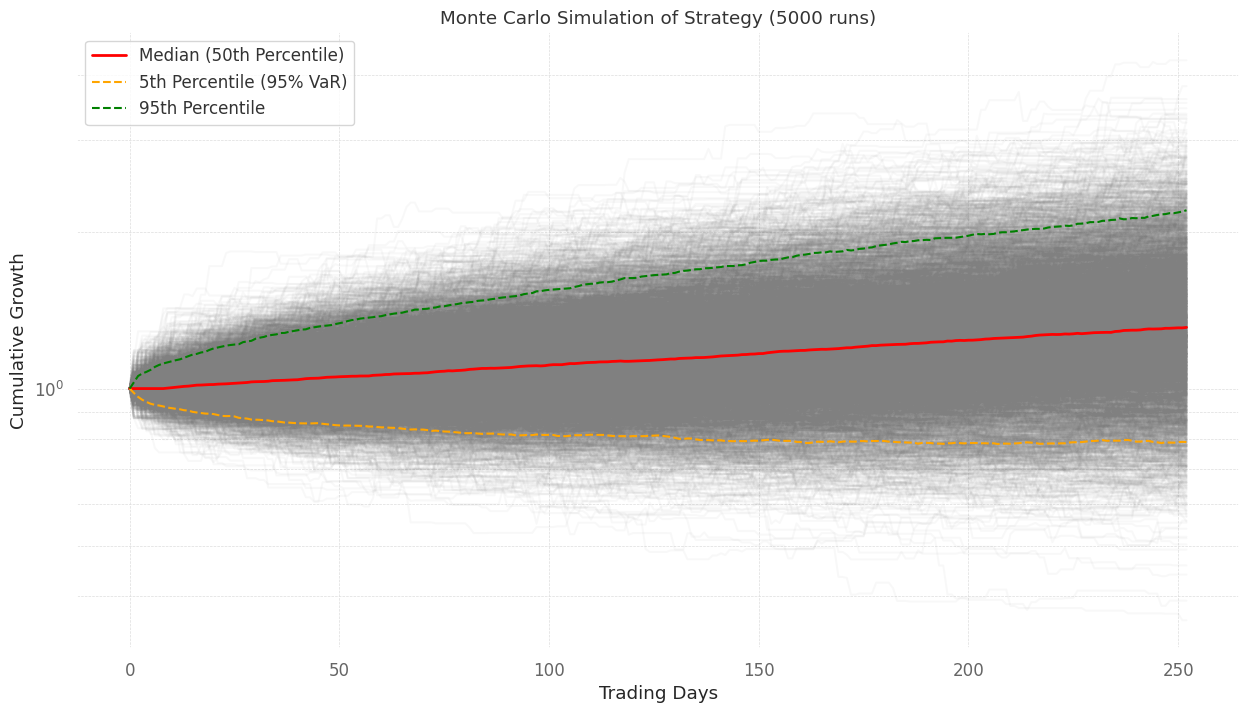

In [32]:
print("Monte Carlo Plot")

plt.figure(figsize=(15, 8))
plt.plot(sim_results, color='gray', alpha=0.05)
plt.plot(
    np.median(sim_results, axis=1),
    color='red',
    linewidth=2,
    label='Median (50th Percentile)'
)
plt.plot(
    np.percentile(sim_results, 5, axis=1),
    color='orange',
    linestyle='--',
    label='5th Percentile (95% VaR)'
)
plt.plot(
    np.percentile(sim_results, 95, axis=1),
    color='green',
    linestyle='--',
    label='95th Percentile'
)
plt.title(f'Monte Carlo Simulation of Strategy ({N_SIMULATIONS} runs)')
plt.xlabel('Trading Days')
plt.ylabel('Cumulative Growth')
plt.yscale('log')
plt.legend(loc='upper left')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.savefig('monte_carlo_spaghetti.png')
print("Plot saved as 'monte_carlo_spaghetti.png'")
plt.show()

In [33]:
print("Monte Carlo 1-Year (252-day) Risk Metrics")
final_outcomes = sim_results[-1, :]
median_return = np.median(final_outcomes)
var_5_percent = np.percentile(final_outcomes, 5)
var_1_percent = np.percentile(final_outcomes, 1)

print(f"Median 1-Year Growth: {median_return:.2f}x")
print(f"95th Percentile Growth: {np.percentile(final_outcomes, 95):.2f}x")
print(f"Worst 5% of outcomes (95% VaR): {var_5_percent:.2f}x (a loss of {(1-var_5_percent)*100:.2f}% or more)")
print(f"Worst 1% of outcomes (99% VaR): {var_1_percent:.2f}x (a loss of {(1-var_1_percent)*100:.2f}% or more)")

Monte Carlo 1-Year (252-day) Risk Metrics
Median 1-Year Growth: 1.31x
95th Percentile Growth: 2.20x
Worst 5% of outcomes (95% VaR): 0.79x (a loss of 21.04% or more)
Worst 1% of outcomes (99% VaR): 0.65x (a loss of 34.99% or more)


In [34]:

import quantstats as qs
strategy_returns = backtest_df['Strategy_Returns'].fillna(0.0)
benchmark_returns = backtest_df['Market_Returns'].fillna(0.0)
strategy_returns = strategy_returns.astype(float)
benchmark_returns = benchmark_returns.astype(float)

report_filename = f'{VOLATILE_TICKER}_strategy_report.html'

qs.reports.html(
    strategy_returns,
    benchmark=benchmark_returns,
    title=f'{VOLATILE_TICKER} Probabilistic Model Report',
    output=report_filename
)

print(f"Successfully generated full report: {report_filename}")


print("\nKey Performance Metrics")

total_days = len(backtest_df.index)
years = total_days / 252.0

cagr = (backtest_df['Cumulative_Strategy_Returns'].iloc[-1]) ** (1/years) - 1
print(f"Strategy CAGR: {cagr*100:.2f}%")


mdd = qs.stats.max_drawdown(strategy_returns)
print(f"Max Drawdown: {mdd*100:.2f}%")

sharpe = qs.stats.sharpe(strategy_returns)
print(f"Sharpe Ratio: {sharpe:.2f}")

sortino = qs.stats.sortino(strategy_returns)
print(f"Sortino Ratio: {sortino:.2f}")

calmar = qs.stats.calmar(strategy_returns)
print(f"Calmar Ratio: {calmar:.2f}")

Successfully generated full report: TSLA_strategy_report.html

Key Performance Metrics
Strategy CAGR: 25.31%
Max Drawdown: -48.95%
Sharpe Ratio: 0.93
Sortino Ratio: 1.58
Calmar Ratio: 0.52


In [35]:
from IPython.display import HTML, display

print(f"Loading report file: {report_filename}...")

try:
    with open(report_filename, 'r', encoding='utf-8') as f:
        html_content = f.read()
    display(HTML(html_content))

except FileNotFoundError:
    print(f"ERROR: The report file '{report_filename}' was not found.")
    print("This likely means the quantstats generation failed in the cell above,")
    print("possibly due to the matplotlib font error.")

Loading report file: TSLA_strategy_report.html...


In [36]:
import itertools
import warnings
from pandas.errors import PerformanceWarning

# Suppress warnings during this heavy loop
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=PerformanceWarning)

param_grid = {
    'profit_take_perc': [0.15, 0.20, 0.25],
    'stop_loss_perc': [0.05, 0.10, 0.15],
    'time_barrier_days': [20, 50, 80]
}


grid_combinations = list(itertools.product(
    param_grid['profit_take_perc'],
    param_grid['stop_loss_perc'],
    param_grid['time_barrier_days']
))

results_list = []

print(f"Testing {len(grid_combinations)} parameter combinations...")

Testing 27 parameter combinations...


In [37]:
CHAMPION_FEATURE_SET = [
    'RSI',
    'MACD',
    'ATR_PERCENT',
    'EMA_DIST',
    'EMA_CROSS_MED',
    'EMA_CROSS_LONG'
]

for i, (p_perc, s_perc, t_days) in enumerate(grid_combinations):

    print(f"\n[Run {i+1}/{len(grid_combinations)}] Testing: P={p_perc*100}%, S={s_perc*100}%, T={t_days} days")

    current_labels = get_triple_barrier_labels(
        data['Close'],
        profit_take_perc=p_perc,
        stop_loss_perc=s_perc,
        time_barrier_days=t_days
    )


    run_data = data.copy()
    run_data['label'] = current_labels

    X = run_data[CHAMPION_FEATURE_SET]
    y = run_data['label']

    combined = pd.concat([X, y], axis=1).dropna()
    X = combined[CHAMPION_FEATURE_SET]
    y = combined['label']

    if len(y.value_counts()) < 2:
        print("  -> Skipping: This combo produced no valid (0 or 1) labels.")
        continue
    tscv = TimeSeriesSplit(n_splits=N_SPLITS)
    all_predictions = pd.Series(np.nan, index=y.index)

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        weight_ratio = y_train.value_counts()[0.0] / y_train.value_counts()[1.0]

        model = xgb.XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            use_label_encoder=False,
            n_estimators=100,
            random_state=42,
            scale_pos_weight=weight_ratio,
            max_depth=3,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8
        )

        model.fit(X_train_scaled, y_train)
        test_probs = model.predict_proba(X_test_scaled)[:, 1]
        all_predictions.iloc[test_index] = (test_probs > PROB_THRESHOLD).astype(int)

    backtest_df = run_data.loc[all_predictions.index].copy()
    backtest_df['Signal'] = all_predictions.shift(1)
    backtest_df['Strategy_Returns'] = (backtest_df['Stock_Returns'] * backtest_df['Signal']).fillna(0.0)
    backtest_df['Cumulative_Strategy_Returns'] = (1 + backtest_df['Strategy_Returns']).cumprod()


    strategy_returns = backtest_df['Strategy_Returns']

    try:
        total_days = len(backtest_df.index)
        years = total_days / 252.0
        cagr = (backtest_df['Cumulative_Strategy_Returns'].iloc[-1]) ** (1/years) - 1
        mdd = qs.stats.max_drawdown(strategy_returns)
        sharpe = qs.stats.sharpe(strategy_returns)
        sortino = qs.stats.sortino(strategy_returns)
        calmar = qs.stats.calmar(strategy_returns)


        results_list.append({
            'Profit %': p_perc * 100,
            'Stop %': s_perc * 100,
            'Time (Days)': t_days,
            'CAGR': cagr,
            'MDD': mdd,
            'Sharpe': sharpe,
            'Sortino': sortino,
            'Calmar': calmar
        })
        print(f"  -> Done. Calmar: {calmar:.2f}, CAGR: {cagr*100:.2f}%")

    except Exception as e:
        print(f"  -> Skipping: Error during metric calculation ({e})")


[Run 1/27] Testing: P=15.0%, S=5.0%, T=20 days
  -> Done. Calmar: 0.25, CAGR: 13.23%

[Run 2/27] Testing: P=15.0%, S=5.0%, T=50 days
  -> Done. Calmar: 0.25, CAGR: 13.23%

[Run 3/27] Testing: P=15.0%, S=5.0%, T=80 days
  -> Done. Calmar: 0.25, CAGR: 13.23%

[Run 4/27] Testing: P=15.0%, S=10.0%, T=20 days
  -> Done. Calmar: 0.47, CAGR: 23.80%

[Run 5/27] Testing: P=15.0%, S=10.0%, T=50 days
  -> Done. Calmar: 0.47, CAGR: 23.80%

[Run 6/27] Testing: P=15.0%, S=10.0%, T=80 days
  -> Done. Calmar: 0.47, CAGR: 23.80%

[Run 7/27] Testing: P=15.0%, S=15.0%, T=20 days
  -> Done. Calmar: 0.48, CAGR: 24.61%

[Run 8/27] Testing: P=15.0%, S=15.0%, T=50 days
  -> Done. Calmar: 0.48, CAGR: 24.61%

[Run 9/27] Testing: P=15.0%, S=15.0%, T=80 days
  -> Done. Calmar: 0.48, CAGR: 24.61%

[Run 10/27] Testing: P=20.0%, S=5.0%, T=20 days
  -> Done. Calmar: 0.66, CAGR: 30.51%

[Run 11/27] Testing: P=20.0%, S=5.0%, T=50 days
  -> Done. Calmar: 0.66, CAGR: 30.51%

[Run 12/27] Testing: P=20.0%, S=5.0%, T=80 da

In [38]:

results_df = pd.DataFrame(results_list)

results_df['CAGR'] = results_df['CAGR'] * 100
results_df['MDD'] = results_df['MDD'] * 100
results_df_sorted = results_df.sort_values(by='Calmar', ascending=False)

print("--- Strategy Sensitivity Analysis Results ---")
print("Sorted by Best Calmar Ratio (Return vs. Drawdown)")

display(results_df_sorted.style.format({
    'CAGR': '{:,.2f}%',
    'MDD': '{:,.2f}%',
    'Sharpe': '{:,.2f}',
    'Sortino': '{:,.2f}',
    'Calmar': '{:,.2f}'
}))

--- Strategy Sensitivity Analysis Results ---
Sorted by Best Calmar Ratio (Return vs. Drawdown)


,Profit %,Stop %,Time (Days),CAGR,MDD,Sharpe,Sortino,Calmar
25,25.000000,15.000000,50,29.88%,-38.16%,1.08,1.88,0.78
24,25.000000,15.000000,20,29.88%,-38.16%,1.08,1.88,0.78
26,25.000000,15.000000,80,29.88%,-38.16%,1.08,1.88,0.78
11,20.000000,5.000000,80,30.51%,-46.11%,1.07,1.84,0.66
9,20.000000,5.000000,20,30.51%,-46.11%,1.07,1.84,0.66
10,20.000000,5.000000,50,30.51%,-46.11%,1.07,1.84,0.66
16,20.000000,15.000000,50,26.36%,-44.40%,0.94,1.55,0.59
17,20.000000,15.000000,80,26.36%,-44.40%,0.94,1.55,0.59
15,20.000000,15.000000,20,26.36%,-44.40%,0.94,1.55,0.59
7,15.000000,15.000000,50,24.61%,-50.84%,0.81,1.28,0.48
